In [1]:
with open("../key.txt", "r") as file:
    API_KEY_CLARIN = file.read().strip()

MODELS_ENDPOINT = "https://services.clarin-pl.eu/api/v1/oapi/models"
COMPLETIONS_ENDPOINT = "https://services.clarin-pl.eu/api/v1/oapi/chat/completions"
CLARIN_BASE_URL = "https://services.clarin-pl.eu/api/v1/oapi"

In [2]:
MODEL_ID = "bielik"

In [1]:
import requests
import pandas as pd
import json
import time
import requests

In [4]:
def prompt_chat_custom_temperature(model_id, prompt, temperature = 0.3):
    url = COMPLETIONS_ENDPOINT
    headers = {"Authorization": f"Bearer {API_KEY_CLARIN}", "Content-Type": "application/json"}
    messages = []
    messages.append({"role": "user", "content": prompt})
    data = {
        "model": model_id,
        "messages": messages,
        "temperature": temperature
        #"max_tokens": max_tokens
    }
    response = requests.post(url, json=data, headers=headers)
    if response.status_code == 200:
        try:
            data = response.json()
            if isinstance(data, dict) and "choices" in data and data["choices"]:
                return data["choices"][0].get("message", {}).get("content", None)
            else:
                return None  # Handle unexpected response structure
        except (ValueError, TypeError, AttributeError):
            return None  # Handle cases where response.json() is None or not as expected
    else:
        return None  # Handle non-200 status codes

In [ ]:
df = pd.read_csv("data/dataset.csv", delimiter="|")
df

In [ ]:
sampled_df = df.sample(n=100, random_state=28, ignore_index=True)
temperatures = [round(i, 1) for i in [x * 0.1 for x in range(11)]]

for index, row in sampled_df.iterrows():
    polish_text = row["pl_text"]
    for temperature in temperatures:
        translation = prompt_chat_custom_temperature(
            MODEL_ID, 
            f"Translate to english and don't add any explanations, write only translation: '{polish_text}'", 
            temperature
        )
        sampled_df.at[index, f'{MODEL_ID}_translation_{temperature}'] = translation
    
    if (index + 1) % 10 == 0:
        print(f"Processed {index + 1} out of {len(sampled_df)} samples...")

sampled_df.to_csv("results/bielik_translations_pl_to_en_temperatures_en_prompt.csv", sep='|', index=False)

Processed 10 out of 100 samples...
Processed 20 out of 100 samples...
Processed 30 out of 100 samples...
Processed 40 out of 100 samples...
Processed 50 out of 100 samples...
Processed 60 out of 100 samples...
Processed 70 out of 100 samples...
Processed 80 out of 100 samples...
Processed 90 out of 100 samples...
Processed 100 out of 100 samples...


In [ ]:
sampled_df = df.sample(n=100, random_state=28, ignore_index=True)

for index, row in sampled_df.iterrows():
    polish_text = row["pl_text"]
    for temperature in temperatures:
        translation = prompt_chat_custom_temperature(
            MODEL_ID, 
            f"Przetłumacz na angielski i nie dodawaj żadnych dodatkowych wyjaśnień, napisz tylko samo tłumaczenie: '{polish_text}'", 
            temperature
        )
        sampled_df.at[index, f'{MODEL_ID}_translation_{temperature}'] = translation
    
    if (index + 1) % 10 == 0:
        print(f"Processed {index + 1} out of {len(sampled_df)} samples...")

sampled_df.to_csv("results/bielik_translations_pl_to_en_temperatures_pl_prompt.csv", sep='|', index=False)

Processed 10 out of 100 samples...
Processed 20 out of 100 samples...
Processed 30 out of 100 samples...
Processed 40 out of 100 samples...
Processed 50 out of 100 samples...
Processed 60 out of 100 samples...
Processed 70 out of 100 samples...
Processed 80 out of 100 samples...
Processed 90 out of 100 samples...
Processed 100 out of 100 samples...


In [2]:
translations_metrics_pl_prompt = pd.read_csv('translations_scores/system_translations_temperatures_basic_metrics.csv')
translations_metrics_en_prompt = pd.read_csv('translations_scores/system_translations_temperatures_en_prompt_basic_metrics.csv')
bielik_translations_metrics_pl_to_en_pl_prompt = pd.read_csv('translations_scores/system_bielik_translations_pl_to_en_temperatures_pl_prompt_basic_metric.csv')
bielik_translations_metrics_pl_to_en_en_prompt = pd.read_csv('translations_scores/system_bielik_translations_pl_to_en_temperatures_en_prompt_basic_metric.csv')

In [3]:
bielik_pl_columns = bielik_translations_metrics_pl_to_en_pl_prompt.columns
bielik_en_columns = bielik_translations_metrics_pl_to_en_en_prompt.columns

bielik_translations_metrics_en_to_pl_pl_prompt = translations_metrics_pl_prompt[bielik_pl_columns]
bielik_translations_metrics_en_to_pl_en_prompt = translations_metrics_en_prompt[bielik_en_columns]

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
metrics = ['comet', 'bertscore', 'chrf', 'bleu']

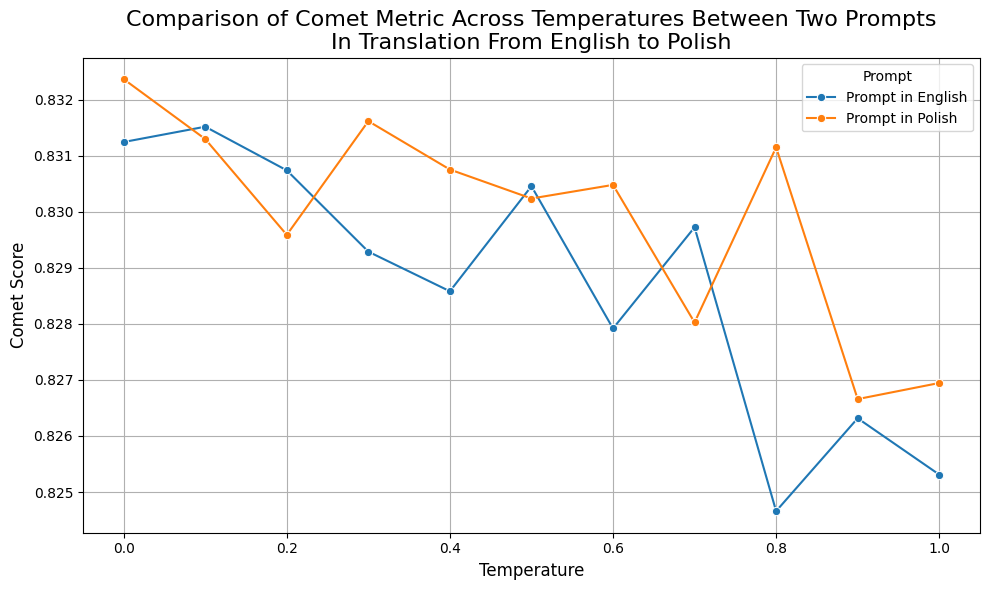

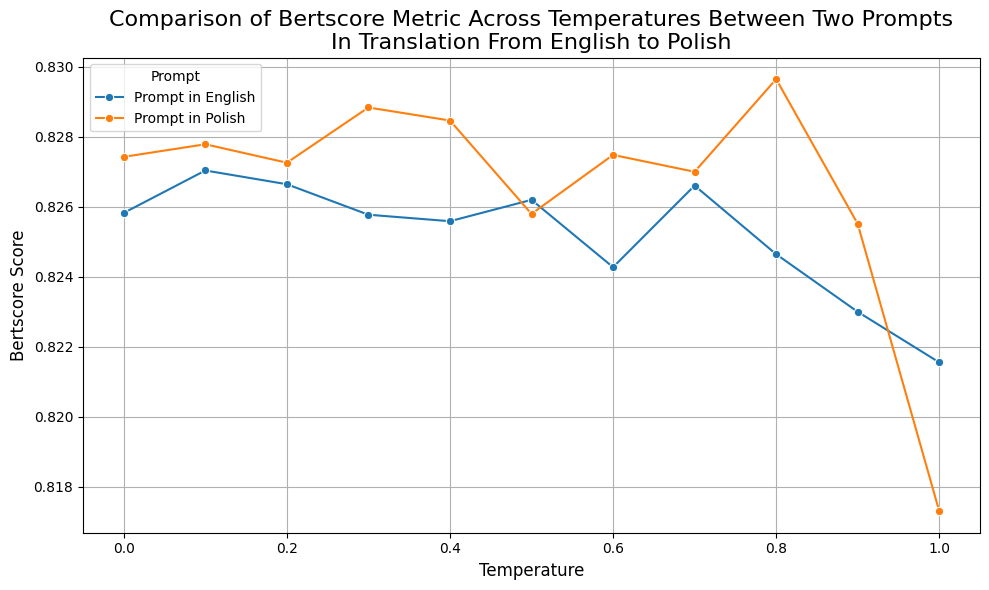

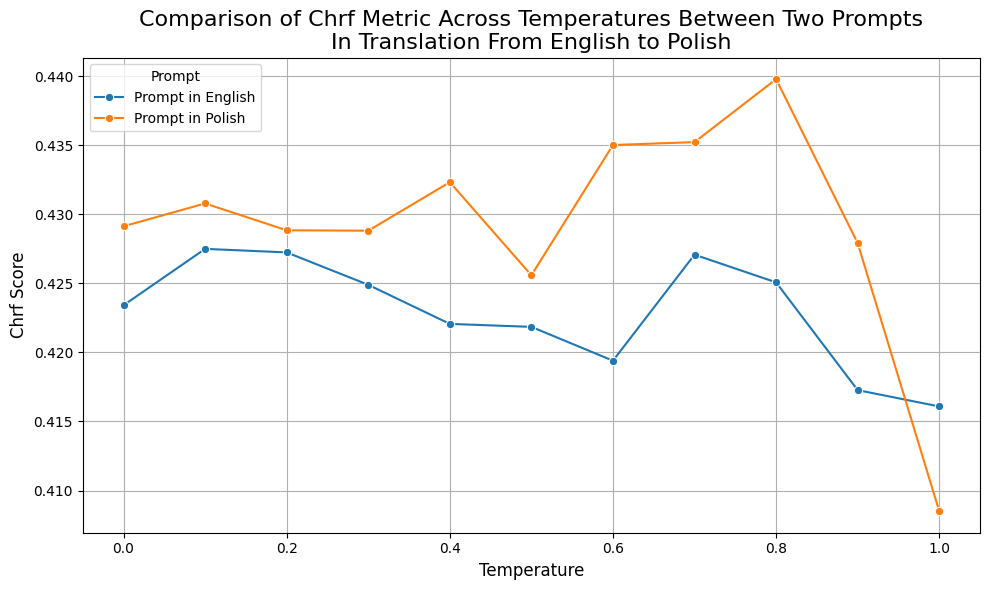

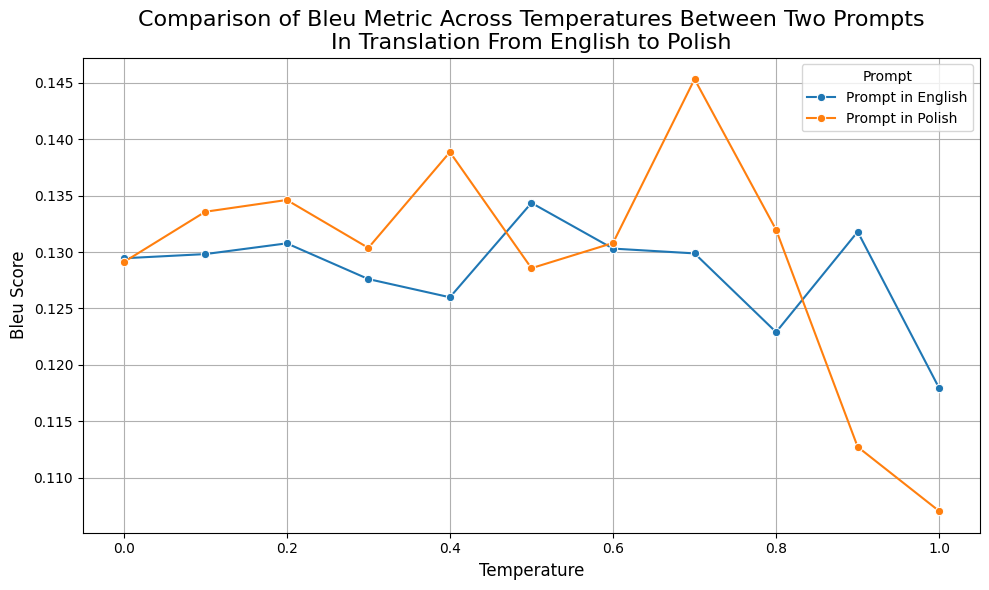

In [ ]:
for metric in metrics:
    columns_to_compare_en = [col for col in bielik_translations_metrics_en_to_pl_en_prompt.columns if metric in col.lower()]
    columns_to_compare_pl = [col for col in bielik_translations_metrics_en_to_pl_pl_prompt.columns if metric in col.lower()]

    # Extract model names, temperatures, and values for both datasets
    comparison_data = []

    # Process the English prompt dataset
    for col in columns_to_compare_en:
        parts = col.split("_")
        model_name = parts[1]  # Extract the model name
        temperature = float(parts[-1]) if len(parts) > 3 else 0.0  # Extract the temperature
        value = bielik_translations_metrics_en_to_pl_en_prompt[col].iloc[0]  # Assuming scores are in the first row
        comparison_data.append({
            "Temperature": temperature,
            "Value": value,
            "Pobudzenie": "Pobudzenie po angielsku"
        })

    # Process the Polish prompt dataset
    for col in columns_to_compare_pl:
        parts = col.split("_")
        model_name = parts[1]  # Extract the model name
        temperature = float(parts[-1]) if len(parts) > 3 else 0.0  # Extract the temperature
        value = bielik_translations_metrics_en_to_pl_pl_prompt[col].iloc[0]  # Assuming scores are in the first row
        comparison_data.append({
            "Temperature": temperature,
            "Value": value,
            "Pobudzenie": "Pobudzenie po polsku"
        })

    # Create a DataFrame for plotting
    comparison_df = pd.DataFrame(comparison_data)

    # Sort the data by Model, Temperature, and Prompt
    comparison_df = comparison_df.sort_values(by=["Temperature", "Pobudzenie"])

    # Plot the line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=comparison_df, x="Temperature", y="Value", hue="Pobudzenie", marker="o", palette="tab10")
    plt.title(f"Comparison of {metric.capitalize()} Metric Across Temperatures Between Two Prompts\nIn Translation From English to Polish", fontsize=16)
    plt.xlabel("Temperature", fontsize=12)
    plt.ylabel(f"{metric.capitalize()} Score", fontsize=12)
    plt.legend(title="Pobudzenie", fontsize=10)
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    plt.show()

In [6]:
import matplotlib.ticker as mticker

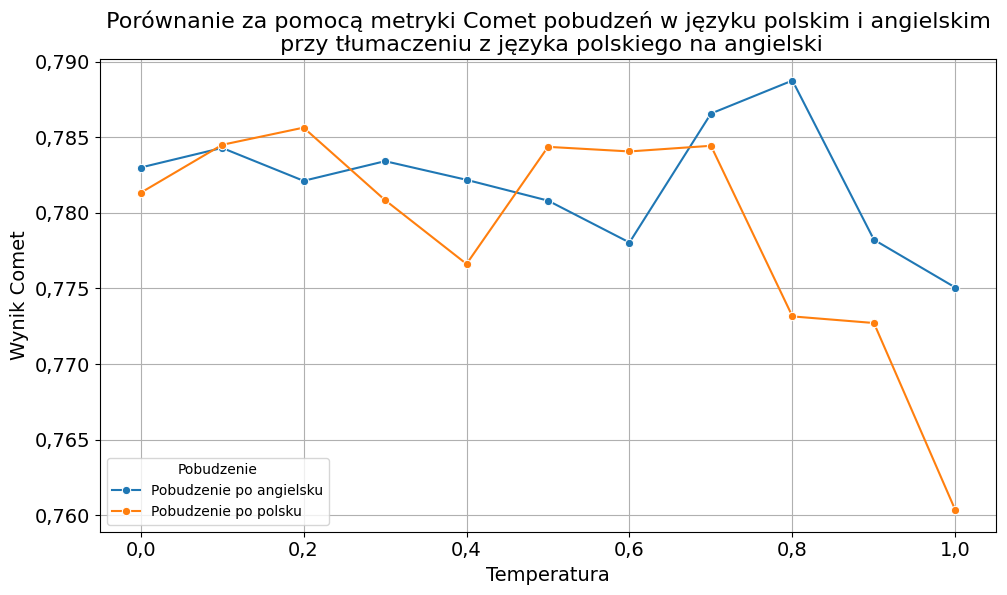

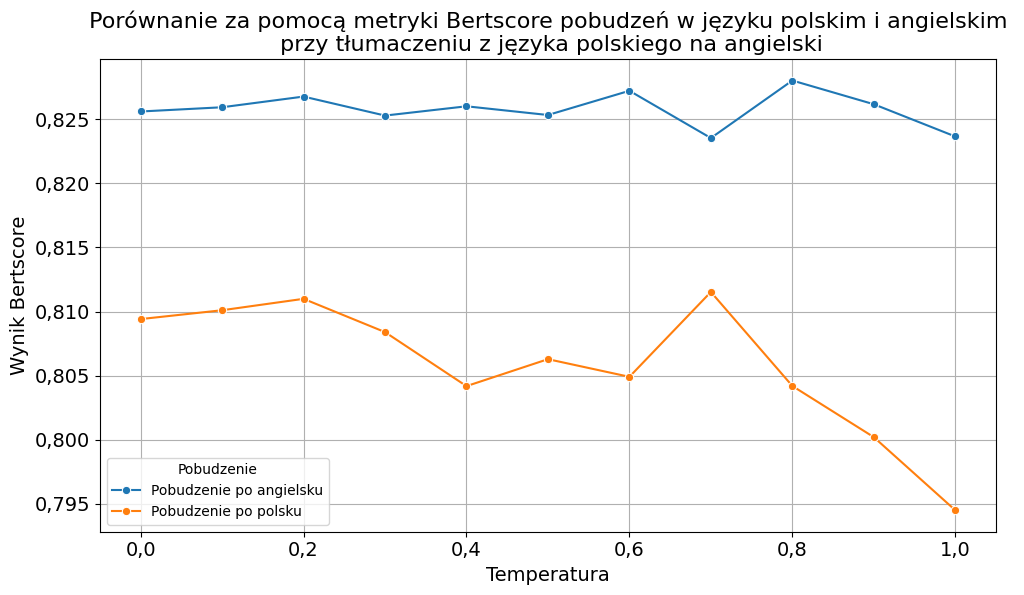

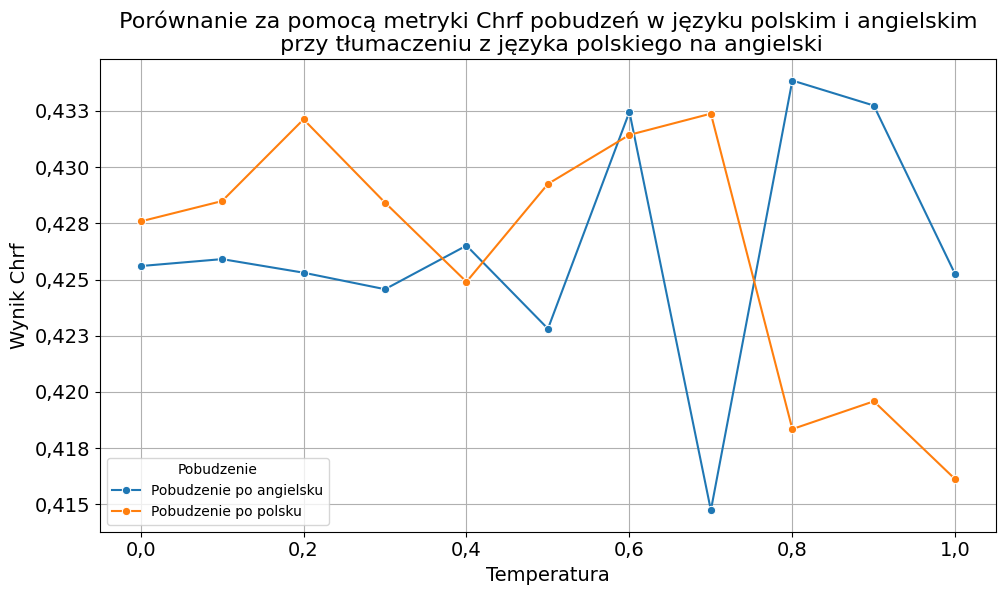

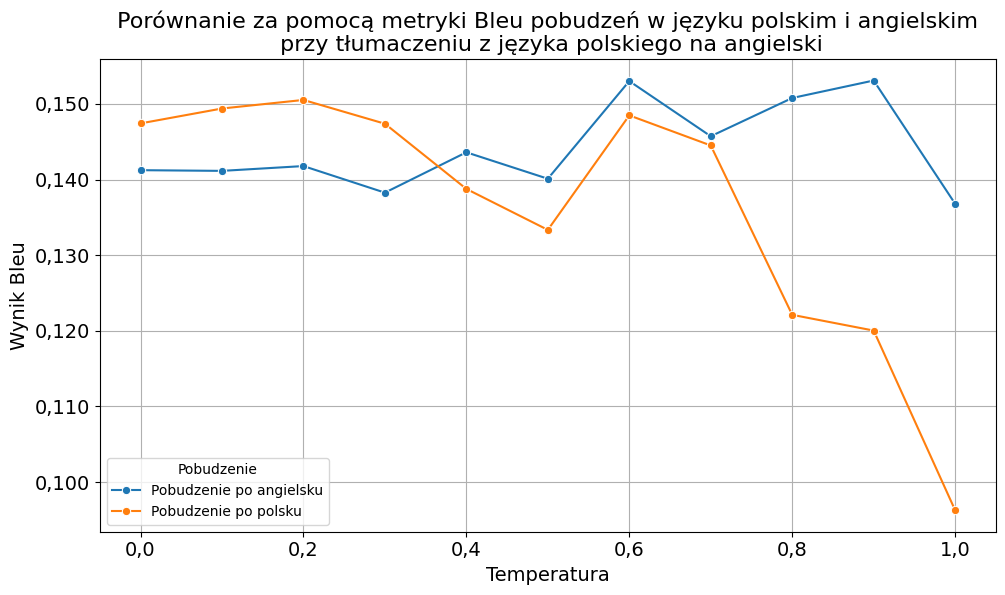

In [7]:
for metric in metrics:
    columns_to_compare_en = [col for col in bielik_translations_metrics_pl_to_en_en_prompt.columns if metric in col.lower()]
    columns_to_compare_pl = [col for col in bielik_translations_metrics_pl_to_en_pl_prompt.columns if metric in col.lower()]

    # Extract model names, temperatures, and values for both datasets
    comparison_data = []

    # Process the English prompt dataset
    for col in columns_to_compare_en:
        parts = col.split("_")
        model_name = parts[1]  # Extract the model name
        temperature = float(parts[-1]) if len(parts) > 3 else 0.0  # Extract the temperature
        value = bielik_translations_metrics_pl_to_en_en_prompt[col].iloc[0]  # Assuming scores are in the first row
        comparison_data.append({
            "Temperature": temperature,
            "Value": value,
            "Pobudzenie": "Pobudzenie po angielsku"
        })

    # Process the Polish prompt dataset
    for col in columns_to_compare_pl:
        parts = col.split("_")
        model_name = parts[1]  # Extract the model name
        temperature = float(parts[-1]) if len(parts) > 3 else 0.0  # Extract the temperature
        value = bielik_translations_metrics_pl_to_en_pl_prompt[col].iloc[0]  # Assuming scores are in the first row
        comparison_data.append({
            "Temperature": temperature,
            "Value": value,
            "Pobudzenie": "Pobudzenie po polsku"
        })

    # Create a DataFrame for plotting
    comparison_df = pd.DataFrame(comparison_data)

    # Sort the data by Model, Temperature, and Prompt
    comparison_df = comparison_df.sort_values(by=["Temperature", "Pobudzenie"])

    # Plot the line plot
    plt.figure(figsize=(10, 6))
    ax = sns.lineplot(data=comparison_df, x="Temperature", y="Value", hue="Pobudzenie", marker="o", palette="tab10")
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.3f}".replace('.', ',')))
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.1f}".replace('.', ',')))
    plt.title(f" Porównanie za pomocą metryki {metric.capitalize()} pobudzeń w języku polskim i angielskim \n przy tłumaczeniu z języka polskiego na angielski", fontsize=16)
    plt.xlabel("Temperatura", fontsize=14)
    plt.ylabel(f"Wynik {metric.capitalize()}", fontsize=14)
    plt.legend(title="Pobudzenie", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(f"figs/{metric}_prompts_comparison_pl_to_en.png", dpi=300, bbox_inches='tight')
    plt.show()
    

In [8]:
combined_data = []

for metric in metrics:
    en_to_pl_columns = [col for col in bielik_translations_metrics_en_to_pl_en_prompt.columns if metric in col.lower()]
    for col in en_to_pl_columns:
        parts = col.split("_")
        temperature = float(parts[-1]) if len(parts) > 3 else 0.0
        value = bielik_translations_metrics_en_to_pl_en_prompt[col].iloc[0]
        combined_data.append({
            "Temperature": temperature,
            "Value": value,
            "Metric": metric.capitalize(),
            "Kierunek tłumaczenia": "Z angielskiego na polski"
        })
    
    pl_to_en_columns = [col for col in bielik_translations_metrics_pl_to_en_en_prompt.columns if metric in col.lower()]
    for col in pl_to_en_columns:
        parts = col.split("_")
        temperature = float(parts[-1]) if len(parts) > 3 else 0.0
        value = bielik_translations_metrics_pl_to_en_en_prompt[col].iloc[0]
        combined_data.append({
            "Temperature": temperature,
            "Value": value,
            "Metric": metric.capitalize(),
            "Kierunek tłumaczenia": "Z polskiego na angielski"
        })

combined_df = pd.DataFrame(combined_data)

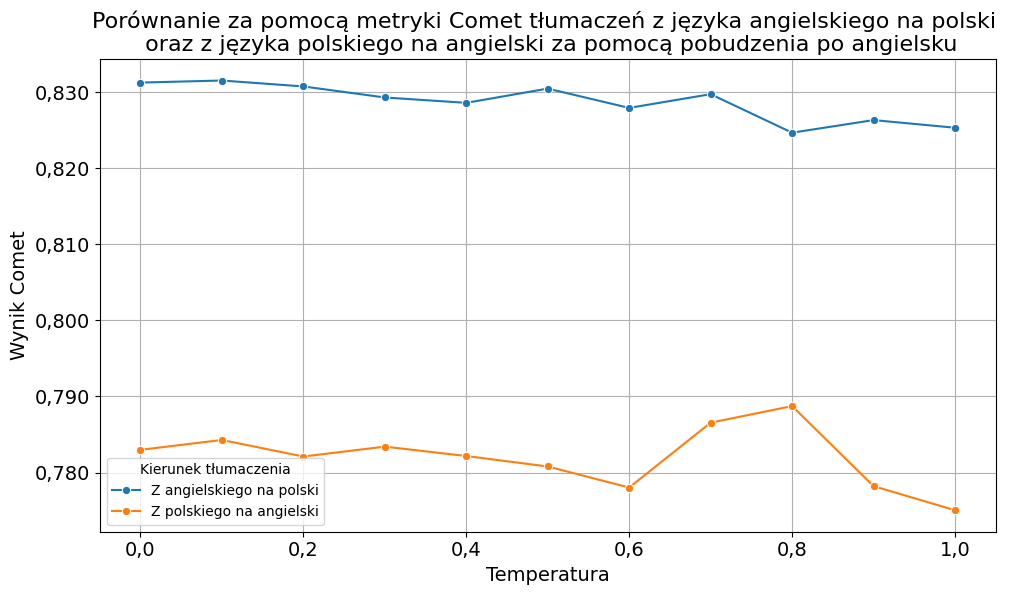

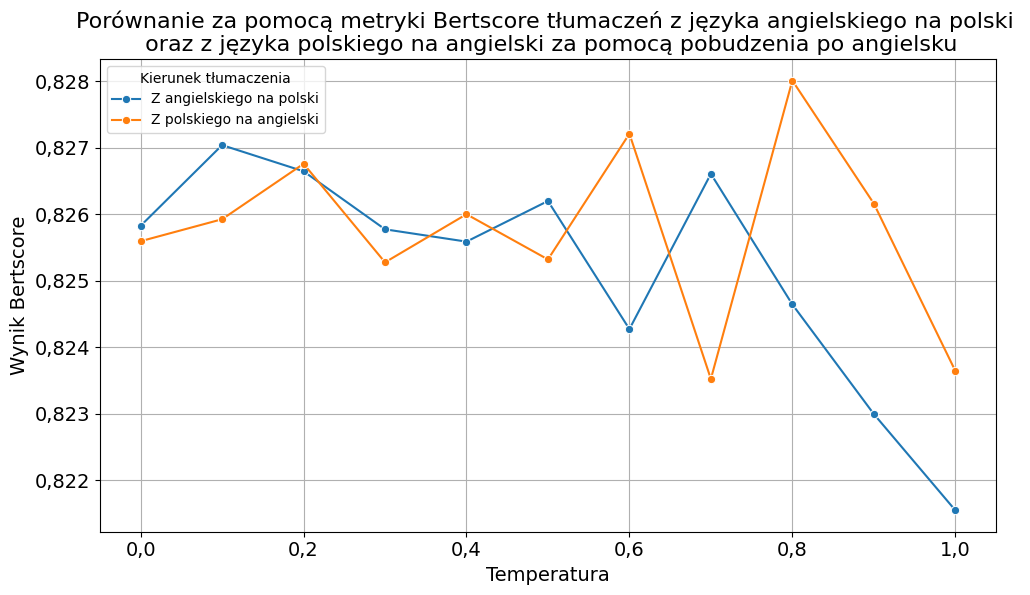

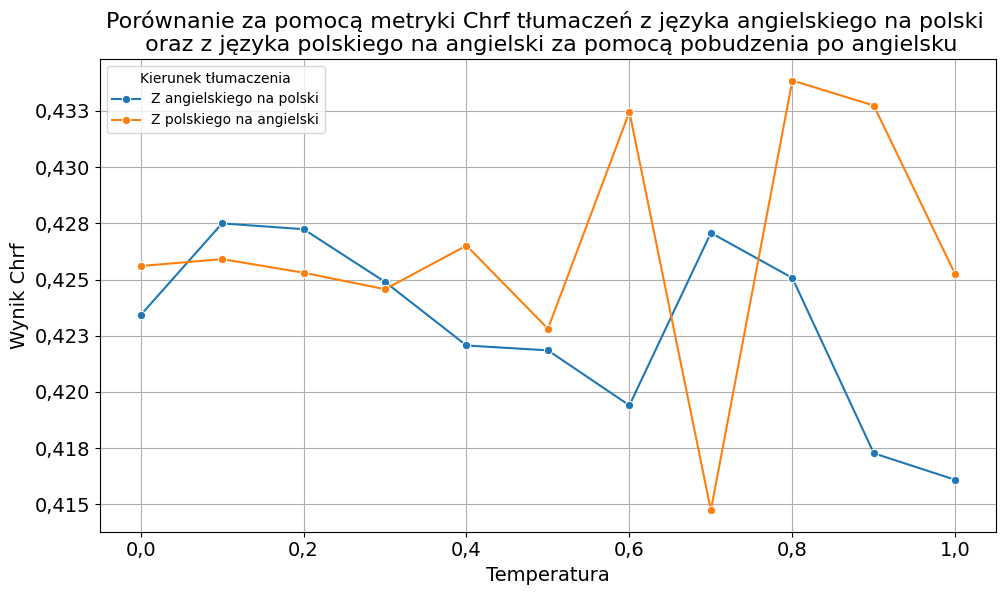

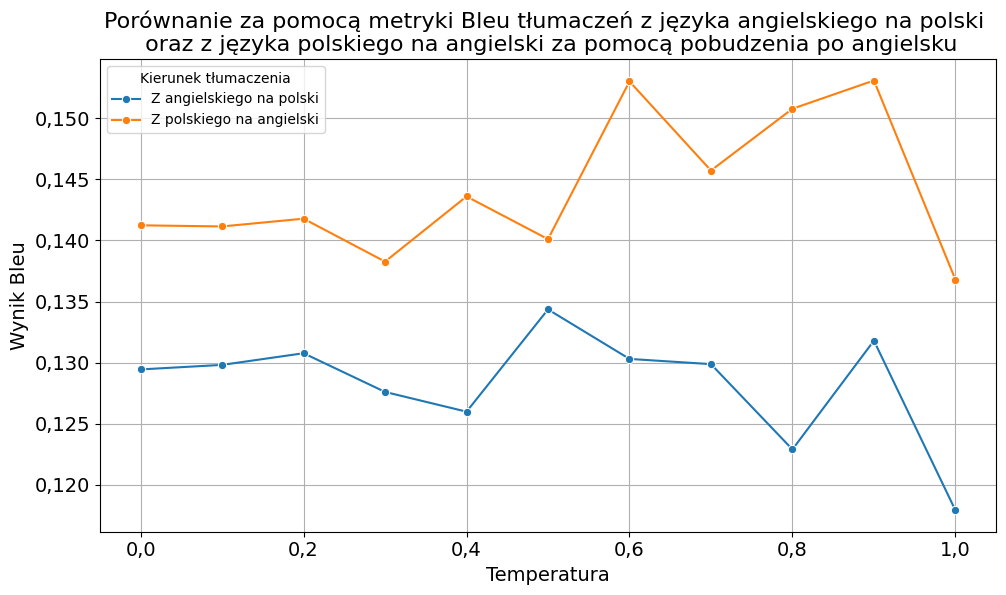

In [9]:
for metric in metrics:
    metric_data = combined_df[combined_df["Metric"] == metric.capitalize()]
    
    plt.figure(figsize=(10, 6))
    ax = sns.lineplot(data=metric_data, x="Temperature", y="Value", hue="Kierunek tłumaczenia", marker="o", palette="tab10")
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.3f}".replace('.', ',')))
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.1f}".replace('.', ',')))
    plt.title(f"Porównanie za pomocą metryki {metric.capitalize()} tłumaczeń z języka angielskiego na polski \n oraz z języka polskiego na angielski za pomocą pobudzenia po angielsku", fontsize=16)
    plt.xlabel("Temperatura", fontsize=14)
    plt.ylabel(f"Wynik {metric.capitalize()}", fontsize=14)
    plt.legend(title="Kierunek tłumaczenia", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(f"figs/{metric}_en_prompt_comparision.png", dpi=300, bbox_inches='tight')
    plt.show()


In [10]:
combined_data = []

for metric in metrics:
    en_to_pl_columns = [col for col in bielik_translations_metrics_en_to_pl_pl_prompt.columns if metric in col.lower()]
    for col in en_to_pl_columns:
        parts = col.split("_")
        temperature = float(parts[-1]) if len(parts) > 3 else 0.0
        value = bielik_translations_metrics_en_to_pl_pl_prompt[col].iloc[0]
        combined_data.append({
            "Temperature": temperature,
            "Value": value,
            "Metric": metric.capitalize(),
            "Kierunek tłumaczenia": "Z angielskiego na polski"
        })
    
    pl_to_en_columns = [col for col in bielik_translations_metrics_pl_to_en_pl_prompt.columns if metric in col.lower()]
    for col in pl_to_en_columns:
        parts = col.split("_")
        temperature = float(parts[-1]) if len(parts) > 3 else 0.0
        value = bielik_translations_metrics_pl_to_en_pl_prompt[col].iloc[0]
        combined_data.append({
            "Temperature": temperature,
            "Value": value,
            "Metric": metric.capitalize(),
            "Kierunek tłumaczenia": "Z polskiego na angielski"
        })

combined_df = pd.DataFrame(combined_data)

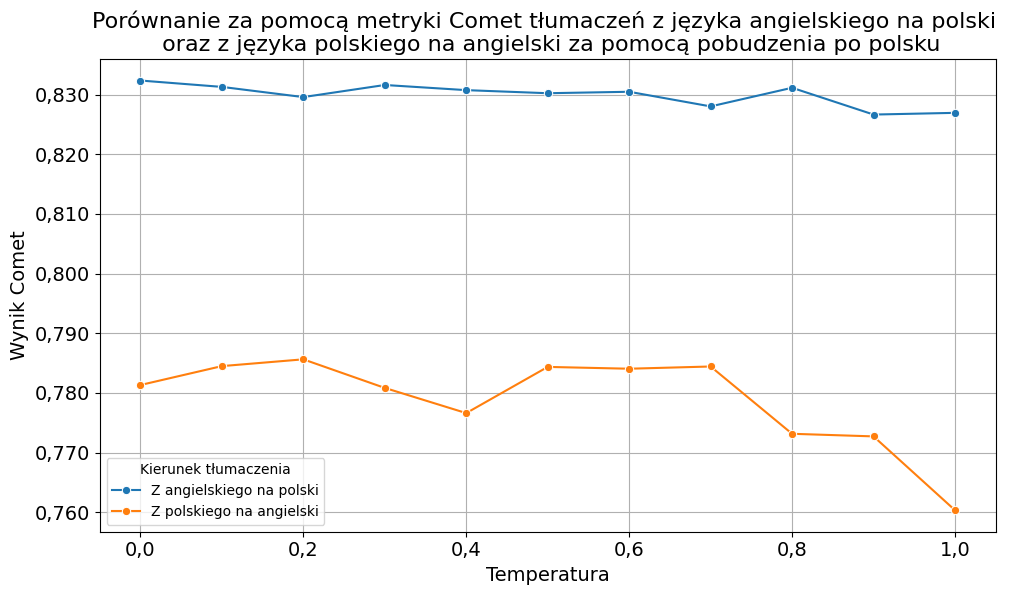

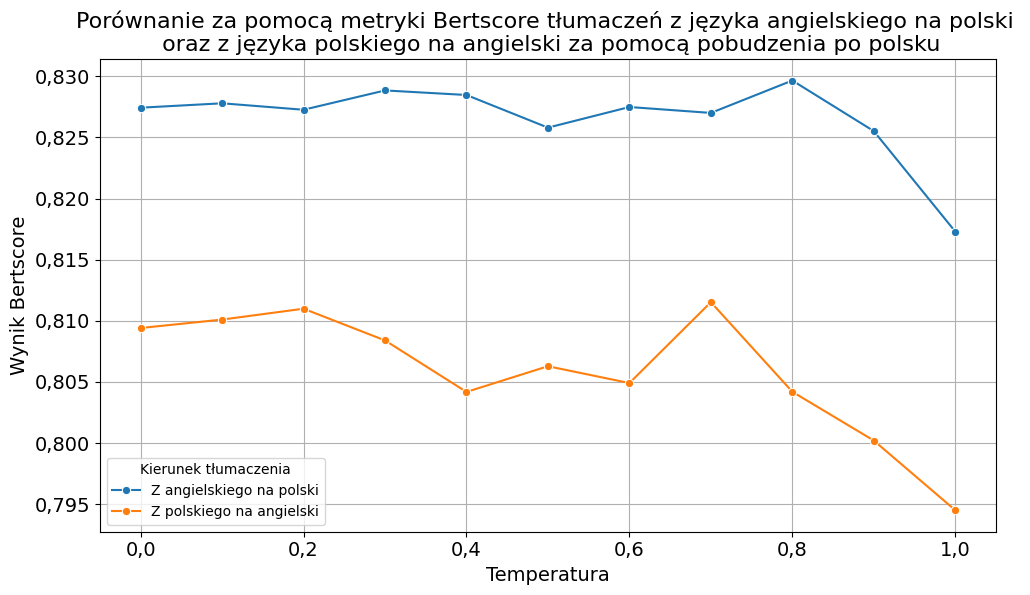

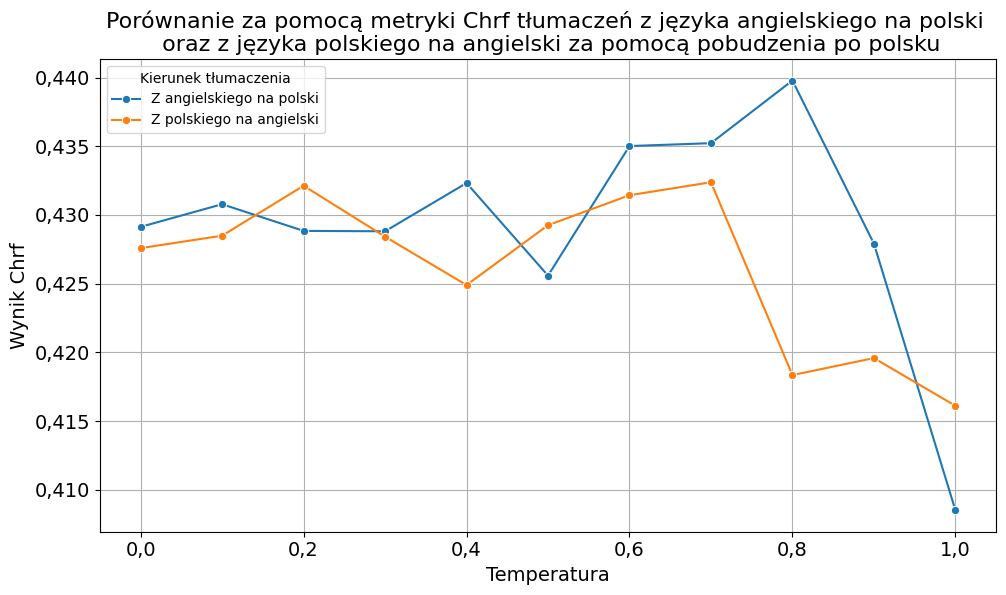

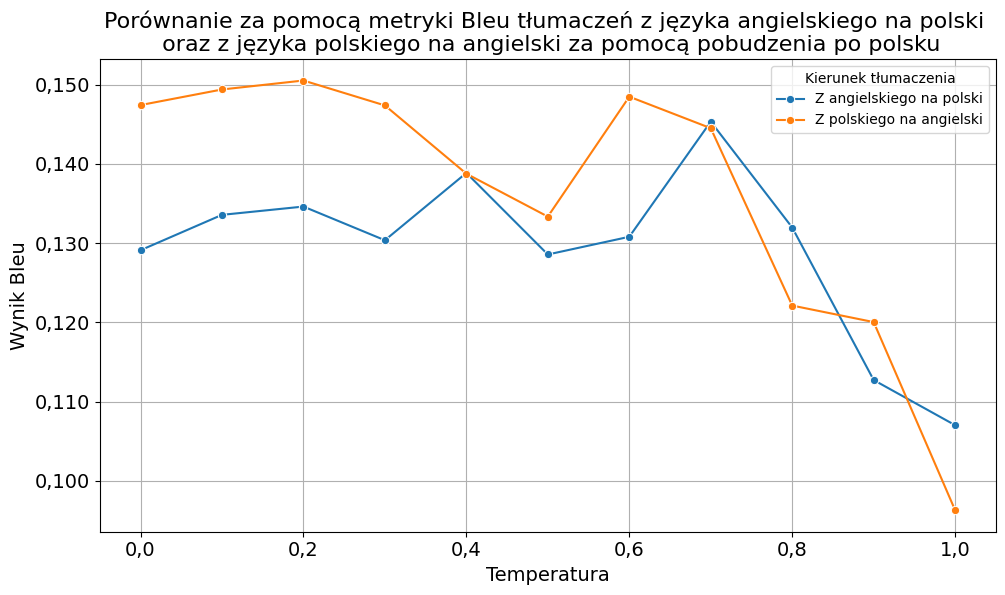

In [11]:
for metric in metrics:
    metric_data = combined_df[combined_df["Metric"] == metric.capitalize()]
    
    plt.figure(figsize=(10, 6))
    ax = sns.lineplot(data=metric_data, x="Temperature", y="Value", hue="Kierunek tłumaczenia", marker="o", palette="tab10")
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.3f}".replace('.', ',')))
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.1f}".replace('.', ',')))
    plt.title(f"Porównanie za pomocą metryki {metric.capitalize()} tłumaczeń z języka angielskiego na polski \n oraz z języka polskiego na angielski za pomocą pobudzenia po polsku", fontsize=16)
    plt.xlabel("Temperatura", fontsize=14)
    plt.ylabel(f"Wynik {metric.capitalize()}", fontsize=14)
    plt.legend(title="Kierunek tłumaczenia", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(f"figs/{metric}_pl_prompt_comparision.png", dpi=300, bbox_inches='tight')
    plt.show()
